# Imports and constants

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, ifft, fftfreq, irfft, rfft,rfftfreq
from IPython.display import Audio

# Audio Wave

## Initialize

In [ ]:
SAMPLE_RATE = 44100  # Hertz
DURATION = 5  # Seconds

In [ ]:
freq_list = np.array([40.0,600.0,2000.0])
N = SAMPLE_RATE * DURATION
xf = fftfreq(N, 1 / SAMPLE_RATE)

In [ ]:
def generate_sine_wave(freq, sample_rate, duration):
    x = np.linspace(0, duration, sample_rate * duration, endpoint=False)
    frequencies = x * freq
    # 2pi because np.sin takes radians
    y = np.sin((2 * np.pi) * frequencies)
    return x, y

## Graphs and Plots

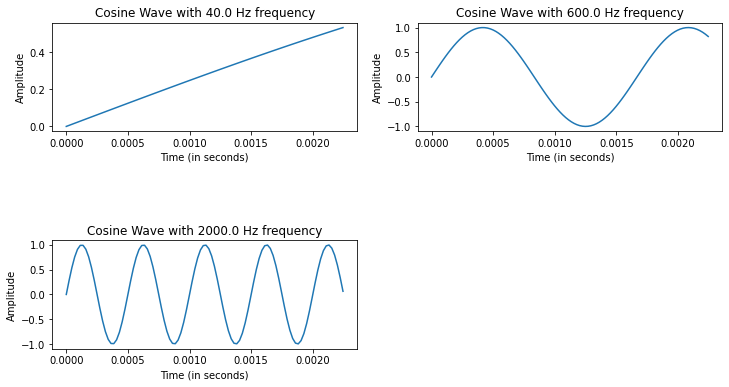

In [ ]:
plt.rcParams["figure.figsize"] = (12,6)
plots_per_row = 2
plt.subplots_adjust(hspace=1)
waves_list = []
for l in range(len(freq_list)):
    plt.subplot(int(len(freq_list)/plots_per_row)+1, plots_per_row, int(l+1))
    x,wave = generate_sine_wave(freq_list[l],SAMPLE_RATE,DURATION)
    waves_list.append(wave)
    plt.plot(x[:100],wave[:100])
    plt.title("Cosine Wave with {} Hz frequency".format(freq_list[l]))
    plt.ylabel("Amplitude")
    plt.xlabel('Time (in seconds)');
plt.show()

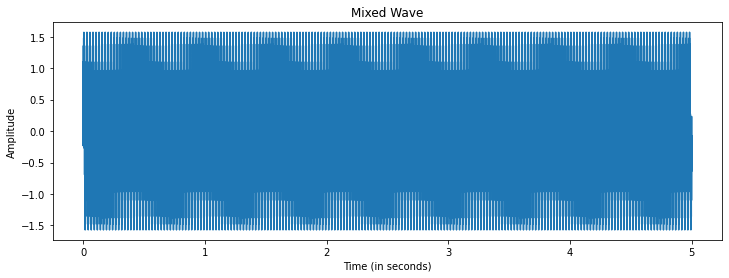

In [ ]:
mixed_signal = waves_list[0] + waves_list[1]*0.5 + waves_list[2]*0.1
x = np.linspace(0, DURATION, SAMPLE_RATE * DURATION, endpoint=False)
plt.rcParams["figure.figsize"] = (12,4)
plt.plot(x,mixed_signal)
plt.title("Mixed Wave")
plt.ylabel("Amplitude")
plt.xlabel('Time (in seconds)');

In [ ]:
normalized_signal = np.int16((mixed_signal / mixed_signal.max()) * 32767)

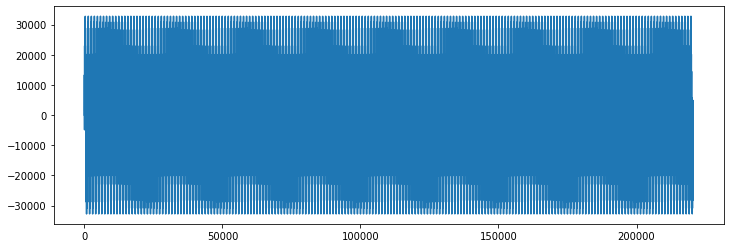

In [ ]:
plt.plot(normalized_signal)
plt.show()

## Original Audio with noise

In [ ]:
Audio(normalized_signal, rate=SAMPLE_RATE)

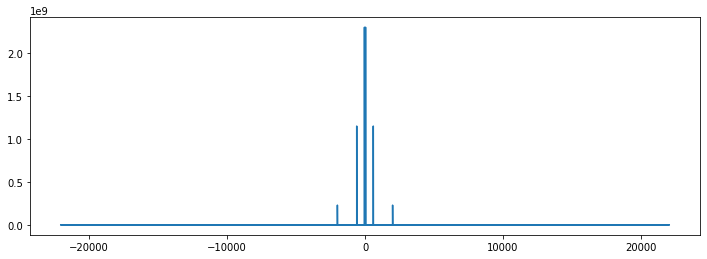

In [ ]:
# Number of samples in normalized_signal
N = SAMPLE_RATE * DURATION

yf = fft(normalized_signal)
xf = fftfreq(N, 1 / SAMPLE_RATE)

plt.plot(xf, np.abs(yf))
plt.show()

## rFFT

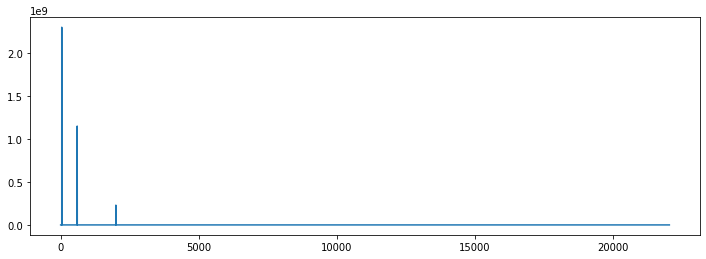

In [ ]:
# Note the extra 'r' at the front
yf = rfft(normalized_signal)
xf = rfftfreq(N, 1 / SAMPLE_RATE)

plt.plot(xf, np.abs(yf))
plt.show()

## Inverse/ back to time sample 

In [ ]:
# The maximum frequency is half the sample rate
points_per_freq = len(xf) / (SAMPLE_RATE / 2)

# Our target frequency is highest frequenct from the list
target_idx = int(points_per_freq * freq_list[len(freq_list)-1])

## Removing Noise

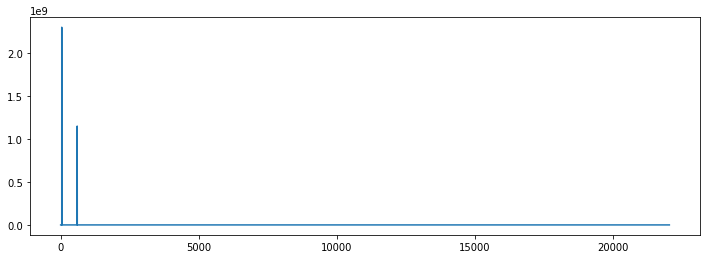

In [ ]:
yf[target_idx - 1 : target_idx + 2] = 0

plt.plot(xf, np.abs(yf))
plt.show()

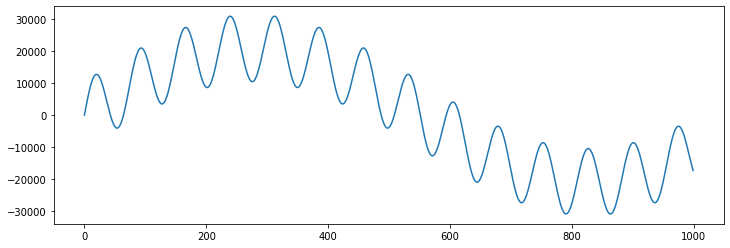

In [ ]:
new_sig = irfft(yf)

plt.plot(new_sig[:1000])
plt.show()

In [ ]:
norm_new_sig = np.int16(new_sig * (32767 / new_sig.max()))

## Clean Audio Out

In [ ]:
Audio(norm_new_sig, rate=SAMPLE_RATE)

# Image

## Initialize

In [ ]:
from skimage import color
from skimage import io
from scipy.fft import fft2, ifft2
import numpy as np
import scipy
import scipy.misc
import matplotlib.pyplot as plt
from scipy import ndimage
from PIL import Image

In [ ]:
!wget -O 'image.png' https://picsum.photos/400/400 

--2022-11-28 12:14:13--  https://picsum.photos/400/400
Resolving picsum.photos (picsum.photos)... 104.26.5.30, 172.67.74.163, 104.26.4.30, ...
Connecting to picsum.photos (picsum.photos)|104.26.5.30|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://i.picsum.photos/id/691/400/400.jpg?hmac=14D074A7Xc18FnjaWbMTHKfr4WZFvBF8ZU1NHoS3TB8 [following]
--2022-11-28 12:14:13--  https://i.picsum.photos/id/691/400/400.jpg?hmac=14D074A7Xc18FnjaWbMTHKfr4WZFvBF8ZU1NHoS3TB8
Resolving i.picsum.photos (i.picsum.photos)... 104.26.4.30, 172.67.74.163, 104.26.5.30, ...
Connecting to i.picsum.photos (i.picsum.photos)|104.26.4.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘image.png’

image.png               [ <=>                ]   8.94K  --.-KB/s    in 0s      

2022-11-28 12:14:13 (50.7 MB/s) - ‘image.png’ saved [9157]



## Displaying Original Image

In [ ]:
img = Image.open('image.png').convert('L')

In [ ]:
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f) ## shift for centering 0.0 (x,y)
magnitude_spectrum = np.log(np.abs(fshift))

plt.subplot(121)
plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122)
plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

## Prep

In [ ]:
rows = np.size(img, 0) #taking the size of the image
cols = np.size(img, 1)
crow, ccol = rows/2, cols/2
max_mask = min(crow,ccol) - 10

## Removing low frequency contents by applying a square window (for masking)

In [ ]:
buckets = 5
masking_windows = np.linspace(0,max_mask,buckets).astype(int)
plt.rcParams["figure.figsize"] = (200,200)
# np.seterr(divide = 'ignore')

for index,size in enumerate(masking_windows):
  f = np.fft.fft2(img)
  fshift = np.fft.fftshift(f) ## shift for centering 0.0 (x,y)
  original = np.copy(fshift)
  fshift[int(crow-size):int(crow+size), int(ccol-size):int(ccol+size)] = 0
  f_ishift= np.fft.ifftshift(original - fshift)

  magnitude_spectrum = np.log(np.abs(fshift))

  img_back = np.fft.ifft2(f_ishift) ## shift for centering 0.0 (x,y)
  img_back = np.abs(img_back)
    
  plt.subplot(buckets,3,(index*3)+1)
  plt.imshow(img, cmap = 'gray')
  plt.title('Input Image')
  plt.xticks([])
  plt.yticks([])


  plt.subplot(buckets,3,(index*3)+2)
  plt.imshow(magnitude_spectrum, cmap = 'gray')
  plt.title('Magnitude Spectrum w/ Mask')
  plt.xticks([])
  plt.yticks([])

  plt.subplot(buckets,3,(index*3)+3)
  plt.imshow(img_back, cmap = 'gray')
  plt.title('Image - Mask')
  plt.xticks([])
  plt.yticks([])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
